## Training Consistency Models

Notebook by Haitz Sáez de Ocáriz Borde \\
A2I Lab, Oxford Robotics Institute, University of Oxford

Content adapted from Yang Song (OpenAI) and FastAI

In this notebook we will show how to **train a consistency model** on the MNIST dataset.

## Background on Consistency Models

Yang Song et al recently introduced a new class of generative models called **consistency models** (https://arxiv.org/abs/2303.01469)

While diffusion models have made significant strides in generating images, audio, and video, their iterative generation process limits their potential for real-time applications due to slow sampling speed. To address this limitation, they introduce consistency models, a new family of generative models that achieve high sample quality without relying on adversarial training. These models are designed to support fast one-step generation, while still allowing for few-step sampling to trade compute for sample quality. Additionally, they enable zero-shot data editing tasks such as image inpainting, colorization, and super-resolution without the need for explicit training. Consistency models can be trained either to distill pre-trained diffusion models or as standalone generative models.

This generative models aim at learning a **consistency function**, which maps any point at time $t$ on a Probability Flow ODE trajectory, to the origin $x_{0}$.

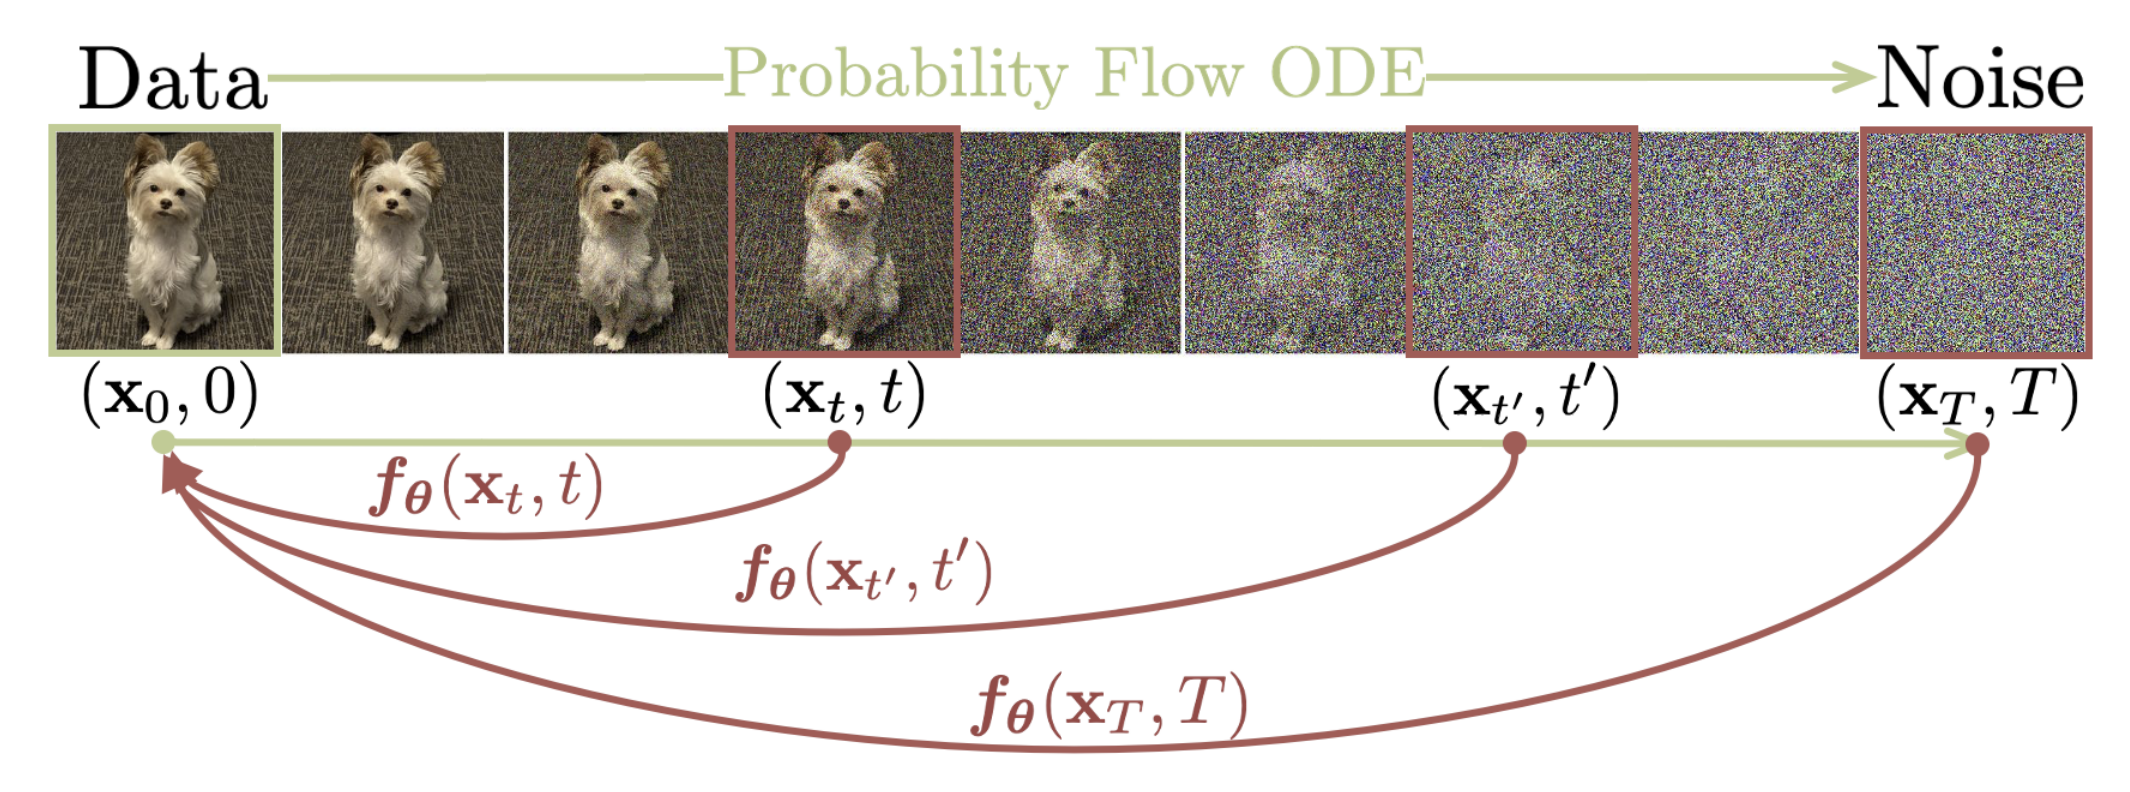

The consistency model is parameterized using skip connections:

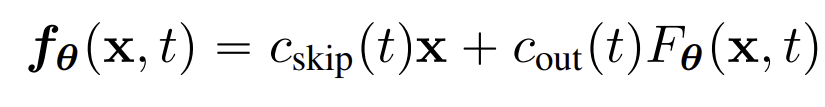

Note that:

* Both $c_{skip}(t)$ and $c_{out}(t)$ are functions of time, rathen than fixed coefficients.
* At the origin of the Probability Flow ODE $c_{skip}(t_{0})=1$ and $c_{out}(t_{0})=0$. 
* The consistency model formulation satisfies the boundary condition: $f(x_{0},t_{0})=x_{0}$.
* In practice, the boundary condition is relaxed to allow for a small offset $\epsilon$ from the original data probability distribution. This is to avoid numerical instabilities and it can be understood as predicting a *slightly noisy version of the original probability distribution*. This is also the case for standard diffusion models.

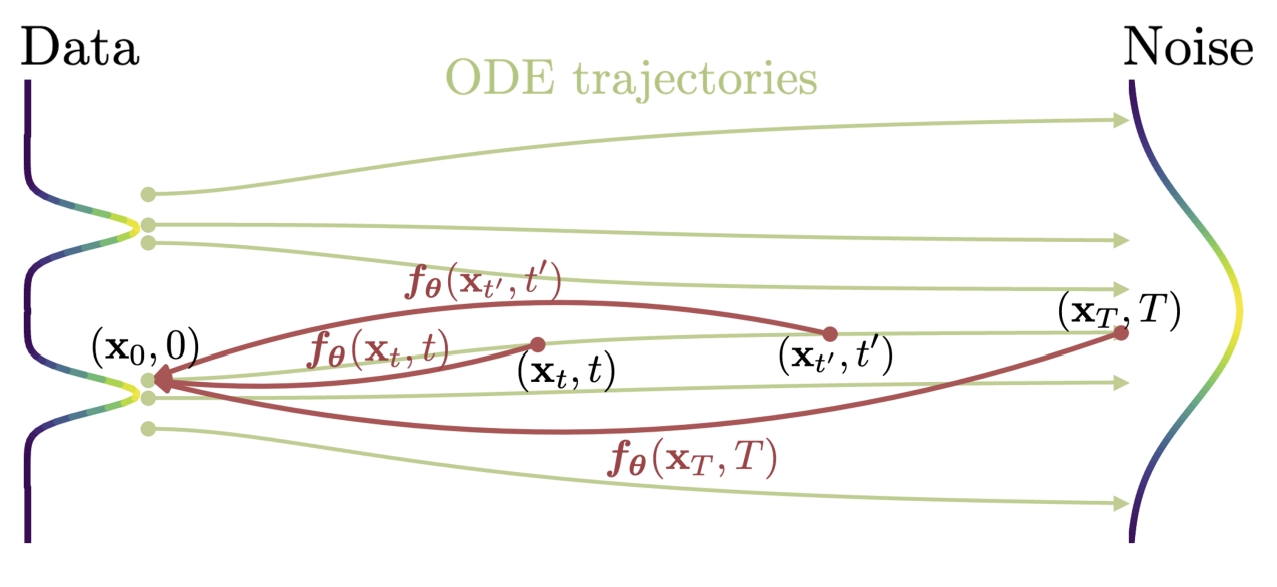

## Imports

(Most Relevant) Installs:

*   Diffusers: The Diffusion Models library from Hugging Face is a Python library for building and training diffusion models, which are generative models that can be used for tasks such as image generation, denoising, and inpainting.

*   Datasets: The Datasets library is a Python library developed by Hugging Face that provides access to a large and growing collection of natural language processing (NLP) datasets and others.

*   Accelerate: The Accelerate library is a Python library developed by Hugging Face that provides a set of tools and utilities for accelerating and optimizing the training and inference of deep learning models. The library provides a variety of features for accelerating deep learning workloads, including automatic mixed precision training, distributed training, and model parallelism.

Git clone:
* FastAI: we import the learner and 2DUNet algorithms from FastAI. Note that the learner function can be a bit 'obscure'. The 2DUNet can alternatively be obtained from diffusers.

Background on UNets:

* UNet is a type of neural network architecture that is commonly used for image segmentation tasks. The name "UNet" comes from the U-shape of the network, which is composed of a contracting path and an expanding path. The contracting path is used to capture context and features from the input image, while the expanding path is used to produce a segmentation mask that has the same size as the input image. The are the main network currently used for Generative Diffusion Models. The UNet-based models in diffusion models typically consist of an encoder that extracts features from the input image and a decoder that generates the output image. The encoder and decoder are connected through a series of skip connections that allow the decoder to access features at different levels of abstraction.




In [1]:
%%capture
!pip install diffusers datasets torcheval accelerate einops
!git clone https://github.com/fastai/course22p2.git

Make sure GPU is available

In [2]:
import torch
torch.cuda.is_available()
!nvidia-smi
%cd course22p2
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
from miniai.imports import *
from miniai.diffusion import *
from diffusers import UNet2DModel
from fastprogress import progress_bar
from glob import glob
from copy import deepcopy
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70
set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

Thu Apr 27 16:01:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading dataset and Data processing

Use HuggingFace Datasets to load the MNIST dataset.

In [84]:
#images and targets
xl,yl = 'image','label' 
#dataset
name = "mnist" 
# batch size
bs = 1024 
# loading dataset
dsd = load_dataset(name) 

# inplace removes the need for a return function
# Data normalization technique
@inplace
def transform_(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

# Apply transformation to dataset
tds = dsd.with_transform(transform_)

# Define dataloader
def collate_consistency(b): 
  return default_collate(b)[xl]

def dl_consistency(ds): 
  return DataLoader(ds, batch_size=bs, collate_fn=collate_consistency, num_workers=8)

# Move dataset to dataloader with splits
dls = DataLoaders(dl_consistency(tds['train']), dl_consistency(tds['test']))

  0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Define the Consistency model

Model parameterization as described in the paper (https://arxiv.org/pdf/2303.01469.pdf - "Appendix C: Additional Experimental Details"):

In [85]:
# Define scaling coefficients
def scalings(t, eps):
    sig_data=0.5
    c_skip = sig_data ** 2 / ((t - eps) ** 2 + sig_data ** 2)
    c_out = (t - eps) * sig_data / (t ** 2 + sig_data ** 2).sqrt()
    return c_skip, c_out

In [86]:
# UNet model to be pasted to the ConsistencyUNet class
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [87]:
# ConsistencyUNet implements the above function "Appendix C: Additional Experimental Details"
class ConsistencyUNet(nn.Module):
    def __init__(self, eps, model):
        super().__init__()
        self.eps = eps # offset from boundary condition at t_0
        self.F = model # UNet
        
    def forward(self, inp):
        x, t = inp
        # sig is the noise i think here
        # .reshape(-1,1,1,1) output will have shape (n, 1, 1, 1) where n is number of elements
        c_skip, c_out = scalings(t.reshape(-1,1,1,1), self.eps)
        # .squeeze() removes dimensions of size 1, for instance shape (32, 1, 1, 16) becomes (32, 16)
        return c_skip * x + c_out * self.F((x, t.squeeze()))

## Consistency Training algorithm

Noise scheduling is a technique used to improve the quality and diversity of the generated images by controlling the amount and type of noise added to the diffusion process at each step. The noise schedule can be designed to add more noise to the diffusion process at the beginning of training when the model is learning the basic structure of the image distribution. As the training progresses, the schedule can gradually decrease the amount of noise added to the diffusion process to allow the model to generate more high-quality images.

* Karras noise scheduling: The schedule starts with a low magnitude of noise and gradually increases it as the training progresses. This helps the generator to learn the underlying structure of the data in the early stages of training, while the later stages focus on adding variation and diversity to the generated images.

The function sigmas_karras does the following:

* Takes in three arguments: n, sigma_min, and sigma_max. It returns a tensor sigmas that is calculated using a noise scheduling technique used for diffusion models.
* The n argument represents the number of steps in the diffusion process. The sigma_min and sigma_max arguments represent the minimum and maximum values of noise levels to be used in the diffusion process. Note that sigma never reaches 0.
* During training the time discretization of the Probability Flow ODE is increased by passing more steps to this function.

In [88]:
# This is a noise scheduling technique used for diffusion.
def sigmas_karras(n, sigma_min=0.005, sigma_max=40., rho=7.):
    # rising from 0 to 1 over n steps
    ramp = torch.linspace(0, 1, n)
    # this is "Time steps" formula
    min_inv_rho = sigma_min ** (1 / rho)
    max_inv_rho = sigma_max ** (1 / rho)
    sigmas = (max_inv_rho + ramp * (min_inv_rho - max_inv_rho)) ** rho
    return sigmas.cuda()

In this section we implement the consistency model training algorithm

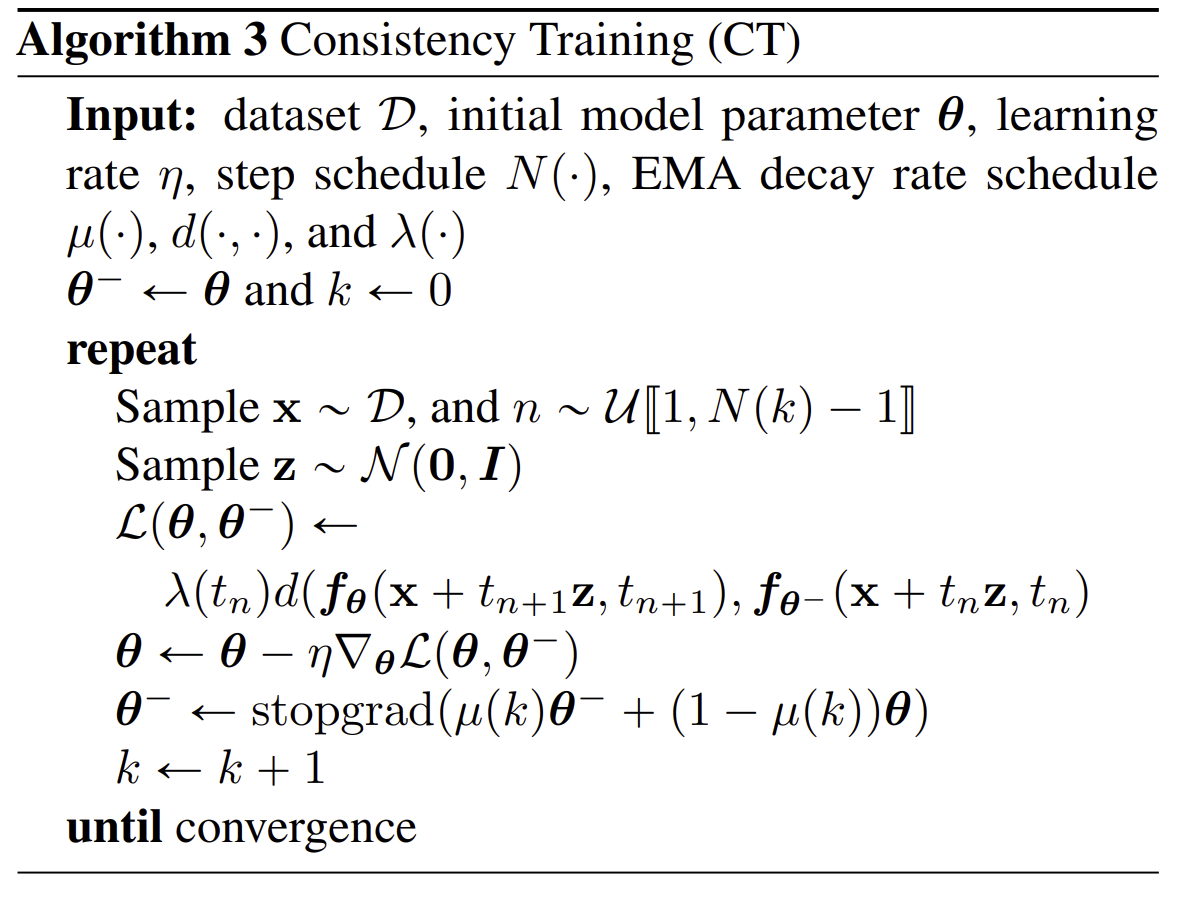

Similar to Reinforcement Learning (RL) we use an **target network** and an *online network*. Yang Song et al found that the EMA update and the stopgrad
operator can greatly stabilize the training process and improve the final performance of the consistency model.

* Before training, we create EMA model.

* During each batch of training, calculate maximum timestep based on the adaptive N schedule. Our new batch is now $((\mathbf{x}_n,\sigma_n),(\mathbf{x}_{n+1},\sigma_{n+1}))$. The second tuple is passed into the EMA model while the first is passed into the regular model and the loss is the MSE between both of these outputs. 

In [89]:
class ConsistencyCB(TrainCB):

    def __init__(self, N=150):
        super().__init__()

        self.N=N
    
    # Called before training loop starts
    def before_fit(self, learn): 

        # Copy model 
        self.ema_model = deepcopy(learn.model)
        self.ema_model.load_state_dict(learn.model.state_dict())
        
    # called before each batch is processed
    def before_batch(self, learn):

        # This value slowly increases over the epochs: this effectively means that the Probability Flow ODE is discretization is increased during training.
        self.N = math.ceil(math.sqrt((learn.epoch+1 * (self.N**2 - 4) / learn.n_epochs) + 4) - 1) + 1

        # .flip(dims=(-1,)) flips along its last dimension eg [1,2,3,4] -> [4,3,2,1]
        noise_sched = sigmas_karras(self.N).flip(dims=(-1,))

        # original images, x_0
        x0 = learn.batch 

        # Cuda device (remember to have GPU available)
        device = x0.device

        #  Time step t: 0 =< t < self.N-1, obtain a random integer tensor of length len(x0)
        t = torch.randint(self.N-1, [len(x0)])

        # Time step t+1: dds 1 to every item in t
        t_1 = t+1

        # Noise levels at time step t
        sig_n = noise_sched[t].reshape(-1,1,1,1).to(device)

        # Noise levels at time step t+1
        sig_n_1 = noise_sched[t_1].reshape(-1,1,1,1).to(device)

        # Creates gaussian noise with same shape as x0
        z = torch.randn_like(x0, device=device)

        # Corrupt image to timestep t
        noised_input_n = x0 + sig_n*z

        # Corrupt image to timestep t+1
        noised_input_n_1 = x0 + sig_n_1*z

        # Batch for training, tuple for the target (tn) and online (tn+1) networks
        learn.batch = (noised_input_n, sig_n), (noised_input_n_1, sig_n_1)

    def predict(self, learn): 

        # n_inp is the number of inputs the model expects to receive
        # Pass data to target network here
        # Here we don't consider the gradients with respect to the target network, they are updated using the EMA in 'after_step' 
        with torch.no_grad(): learn.preds = self.ema_model(*learn.batch[:self.n_inp]) 

    def get_loss(self, learn): 

        # Pass data to online network here and impose consistency property between both predictions
        # For the online network we do consider the gradients
        learn.loss = learn.loss_func(learn.preds, learn.model(*learn.batch[self.n_inp:]))

    # Called after each optimization step to update the target network
    def after_step(self, learn):
        with torch.no_grad():
            mu = math.exp(2 * math.log(0.95) / self.N)
            # Update \theta_{-}
            for p, ema_p in zip(learn.model.parameters(), self.ema_model.parameters()):
                ema_p.mul_(mu).add_(p, alpha=1 - mu)

## Model Training

In [90]:
# lr is the learning rate
lr = 1e-4

# Epochs, complete passes through the training set
epochs = 100

# Optimisation function
opt_func = optim.AdamW

# Callbacks to run
# DeviceCB, ProgressCB, MetricsCB are all imported
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), ConsistencyCB()]

# Setup the neural network
unet = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 16, 16, 16), norm_num_groups=16)
model = ConsistencyUNet(0.002, unet)

# Setup the learner with model, dataset, mean squared error loss, learning rate, callbacks, optimisation function
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.323,0,train
0.287,0,eval
0.280,1,train
0.269,1,eval
0.253,2,train
0.233,2,eval
0.218,3,train
0.204,3,eval
0.194,4,train
0.184,4,eval


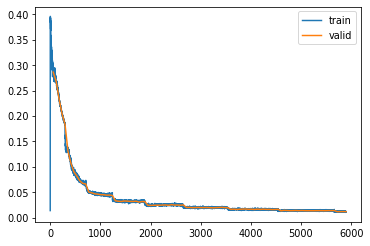

In [91]:
# Start training
learn.fit(epochs)

Note that we find some sudden jumps in the loss function during training, this is due to the increasing time discretization of the Probability Flow ODE during training.

## Sampling

In [92]:
# Clean cache
import gc
gc.collect()
torch.cuda.empty_cache()

Single step generation: one pass throught the neural network

In [93]:
def one_step_sample(model,sz):

    #Change model to eval mode
    model.eval() 

    lastN = learn.cbs[-1].N

    # Get the maximum variance during training
    sig = sigmas_karras(lastN).flip(dims=(-1,))[-1] 

    # Create noise tensor and scale it
    x = torch.randn(sz).cuda() * sig 

    # sig[None] is equivalent to sig.unsqueeze(0)
    sig = sig[None] * torch.ones((len(x),1)).cuda().reshape(-1,1,1,1) # reshape it appropriately

    # Avoid storing gradients during inference to make code more efficient
    with torch.no_grad():
      prediction = model((x,sig)) # simply return model output
    return prediction

In [94]:
# Input tensor dimension
sz = (25, 1, 32, 32) 
# Single step generation
s = one_step_sample(learn.model,sz)

Visualize generated samples.

* These samples are equivalent to "jumping" directly from the end of the Probability Flow ODE to the original data probability distribution in a single step.

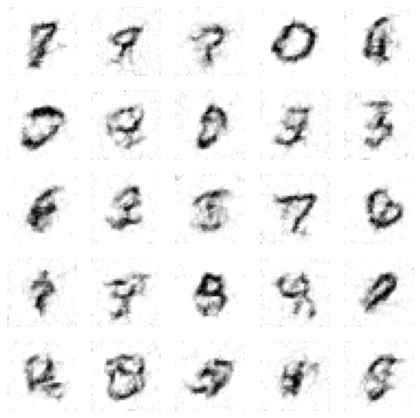

In [95]:
show_images(s[:25].clamp(-1,1), imsize=1.5)

We can use a multi-step algorithm for sample generation. Remember, there is a trade between sample quality and computation.

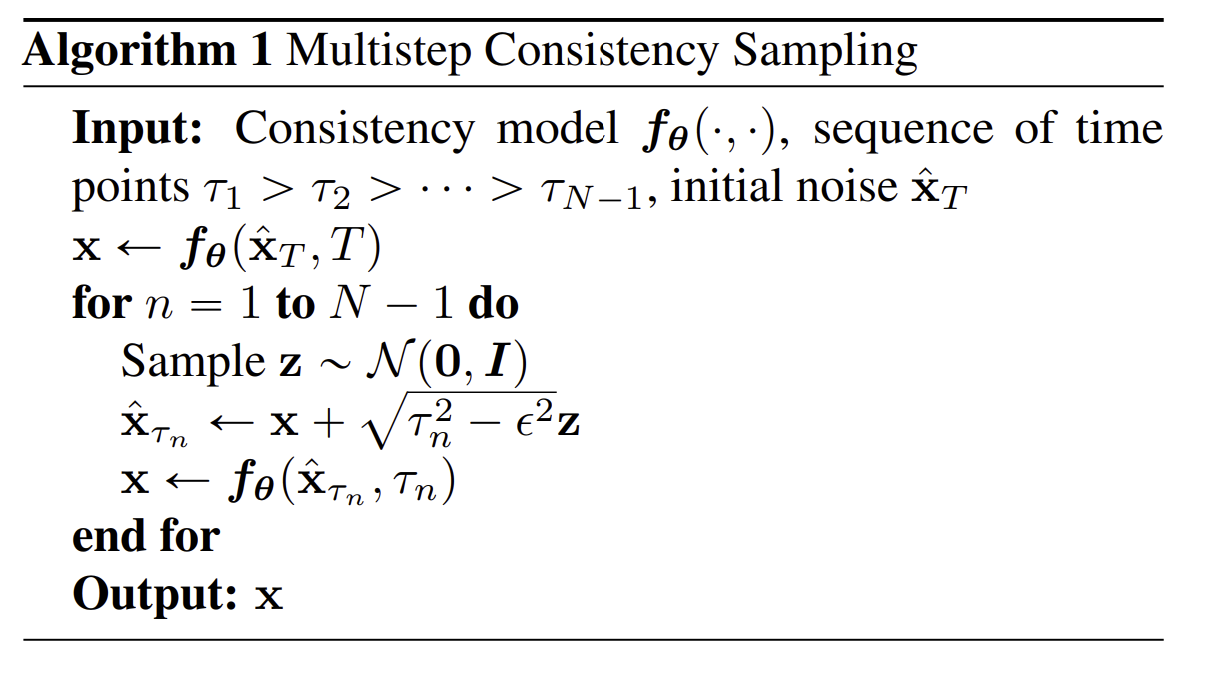

In [108]:
# Use original scheduler
sigmas = sigmas_karras(100).flip(dims=(-1,)).tolist()[1:]


x=s
for sig in reversed(sigmas[:]):
    z = torch.randn_like(x)
    # adds noise
    x = x + math.sqrt((sig)**2 - learn.model.eps**2) * torch.randn(sz).cuda()
    # this is just broadcasting sig to shape (len(x), 1) then reshaping eg result is [ [[[5.0]]], [[[5.0]]], ... etc]
    sig = tensor(sig)[None].cuda() * torch.ones((len(x),1)).cuda().reshape(-1,1,1,1)
    # Avoid storing gradients during inference to make code more efficient
    with torch.no_grad():
      x = learn.model((x, sig))
s=x

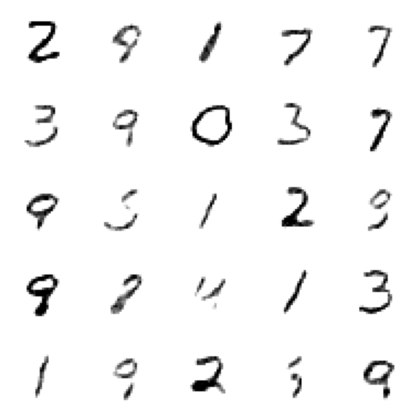

In [109]:
show_images(s[:25].clamp(-1,1), imsize=1.5)

In [100]:
# Alternative schedule
sigmas = [0.5,1.0,2.0,3.0,4.0,5.0,10.0,15.0,20.0]

x=s
for sig in reversed(sigmas[:]):
    z = torch.randn_like(x)
    # adds noise
    x = x + math.sqrt((sig)**2 - learn.model.eps**2) * torch.randn(sz).cuda()
    # this is just broadcasting sig to shape (len(x), 1) then reshaping eg result is [ [[[5.0]]], [[[5.0]]], ... etc]
    sig = tensor(sig)[None].cuda() * torch.ones((len(x),1)).cuda().reshape(-1,1,1,1)
    # Avoid storing gradients during inference to make code more efficient
    with torch.no_grad():
      x = learn.model((x, sig))
s=x

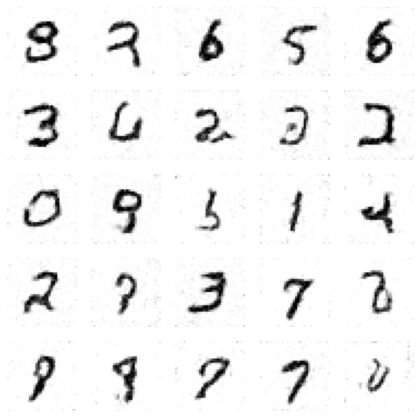

In [101]:
show_images(s[:25].clamp(-1,1), imsize=1.5)